In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.signal import butter, filtfilt, stft
import pywt

from collections import defaultdict


destination = 'collections_20250422_frequency'

# 設定帶通濾波器參數
lowcut = 60_000      # 60 kHz
highcut = 400_000    # 400 kHz
fs = 1_000_000       # 1 MHz

def bandpass_filter(data, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, cutoff, order=4):
    """
    Low-pass filter for 1D signal.
    :param data: Input signal (1D array)
    :param cutoff: Cutoff frequency (Hz)
    :param order: Filter order
    :return: Filtered signal
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

def wavelet_denoise(data, wavelet='db4', threshold_method='soft'):
    maxlev = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet).dec_len)
    # maxlev = 8
    coeffs = pywt.wavedec(data, wavelet, level=maxlev)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs[1:] = [pywt.threshold(c, value=uthresh, mode=threshold_method) for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def plot_spectrum_default(label_list, freq_list, spec_list, enabled_db, enabled_functions, figsize=(7, 5)):
    label_spec_map = defaultdict(list)
    label_freq_map = {}

    for label, freq, spec in zip(label_list, freq_list, spec_list):
        label_spec_map[label].append(spec)
        label_freq_map[label] = freq  # 頻率軸對於同一 label 都一樣

    # 計算統計量
    stat_spec_map = {}
    for label, specs in label_spec_map.items():
        arr = np.vstack(specs)
        stat_spec_map[label] = {
            # 'mean': np.mean(arr, axis=0),
            'min': np.min(arr, axis=0),
            'max': np.max(arr, axis=0),
            'median': np.median(arr, axis=0),
            'q1': np.percentile(arr, 25, axis=0),
            'q3': np.percentile(arr, 75, axis=0),
        }

    # 使用subplot把各統計頻譜分開繪製
    n_labels = len(stat_spec_map)
    n_cols = 2
    n_rows = (n_labels + n_cols - 1) // n_cols
    col_size, row_size = figsize

    plt.figure(figsize=(col_size * n_cols, row_size * n_rows))
    for i, (label, stats) in enumerate(stat_spec_map.items()):
        freq = label_freq_map[label] / 1000  # kHz
        plt.subplot(n_rows, n_cols, i + 1)
        # plt.plot(freq, stats['mean'], label='Mean')
        plt.plot(freq, stats['max'], label='Max')
        plt.plot(freq, stats['q3'], label='Q3')
        plt.plot(freq, stats['median'], label='Median')
        plt.plot(freq, stats['q1'], label='Q1')
        plt.plot(freq, stats['min'], label='Min')
        plt.xlabel('Frequency (kHz)')
        plt.ylabel(f'Energy{enabled_db}')
        plt.title(f'Label: {label}{enabled_functions}')
        plt.legend(fontsize='small')
        plt.tight_layout()
    plt.show()

def plot_spectrum(label_list, freq_list, spec_list, enabled_db, enabled_functions, figsize=(10, 6), presentage = None, custom_title = None):

    label_spec_map = defaultdict(list)
    label_freq_map = {}

    for label, freq, spec in zip(label_list, freq_list, spec_list):
        label_spec_map[label].append(spec)
        label_freq_map[label] = freq  # 頻率軸對於同一 label 都一樣

    # 計算統計量
    stat_spec_map = {}
    for label, specs in label_spec_map.items():
        arr = np.vstack(specs)
        stat_spec_map[label] = {
            'data': np.mean(arr, axis=0) if presentage is None
            else np.min(arr, axis=0) if presentage <= 0
            else np.max(arr, axis=0) if presentage >= 100
            else np.percentile(arr, presentage, axis=0),
        }

    plt.figure(figsize=tuple(figsize))
    for label, stats in stat_spec_map.items():
        freq = label_freq_map[label] / 1000  # kHz
        # 可根據需求選擇要畫哪些統計量
        plt.plot(freq, stats['data'], label=f'{label}')
        
    plt.xlabel('Frequency (kHz)')
    plt.ylabel(f'Energy{enabled_db}')
    
    title = 'mean' if presentage is None \
        else 'min' if presentage <= 0 \
        else 'max' if presentage >= 100 \
        else f'{presentage}%'
    
    plt.title(custom_title or f'Spectrum [{title}]{enabled_functions}')
    
    plt.grid()
    plt.legend(fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

def process_data(
    file_path,
    nfft = None,
    enable_db = False,
    enable_wavelet_denoise = False,
    enable_bandpass_filter = False,
    label_transformer = lambda label: label,
    label_skipper = lambda label: False
):
    destination_file_list = []
    # source_file_list = []
    signal_list = []
    label_list = []
    spec_list = []
    freq_list = []
    
    enabled_functions = []
    
    if enable_bandpass_filter:
        enabled_functions.append(f'Filtered ({lowcut / 1000} - {highcut / 1000} kHz)')
        
    if enable_wavelet_denoise:
        enabled_functions.append('Denoised')
        
        
    
    for root, dirs, files in os.walk(file_path):

        label = root.split('\\')[-1].split('captured_data_')[-1].split('_collection')[0]
        label = label.split('_cycle')[0].split('_directly')[0]
        
        label = label_transformer(label)
        
        if label_skipper(label):
            continue
        
        for file in files:
            if file.endswith('.csv'):
                
                label_list.append(label)
                
                destination_file_list.append(os.path.join(destination, root.split('\\')[-1], file))
                
                signal = pd.read_csv(os.path.join(root, file)).to_numpy().flatten()
                signal = signal / 4095
                signal = signal - np.mean(signal)
                
                if enable_bandpass_filter:
                    signal = bandpass_filter(signal)
                    
                if enable_wavelet_denoise:
                    signal = wavelet_denoise(signal)
                
                signal = signal / np.max(np.abs(signal))
                
                signal_list.append(signal)
                
                nfft__ = nfft or len(signal)
                
                freq = np.fft.rfftfreq(n=nfft__, d=1/fs)
                
                freq_list.append(freq)
                
                spec = np.abs(np.fft.rfft(signal, n=nfft__))
                
                if enable_db:
                    spec = 10 * np.log10(spec + 1e-10)
                
                spec_list.append(spec)
                
    return signal_list, label_list, spec_list, freq_list, destination_file_list, ' (' + ', '.join(enabled_functions) + ')' if enabled_functions else '', ' (dB)' if enable_db else ''

In [2]:
def skip_label(label):
    # 這裡可以根據需要定義要跳過的標籤
    return label in ['sand-lagre', 'sand-large']

signal_list, label_list, spec_list, freq_list, _, enabled_functions, enabled_db = process_data(
    file_path = '20250428',
    # file_path = 'collections_20250422',
    
    # nfft=522 * 2 - 1,
    
    enable_db = False,
    enable_wavelet_denoise = False,
    enable_bandpass_filter = False,
    label_transformer = lambda label: label,
    label_skipper = skip_label,
)

In [3]:
# # 隨機選一個 signal_list 的訊號，同時繪製時域與頻域(FFT)圖
# if signal_list:
#     idx = np.random.randint(len(signal_list))
#     sig = signal_list[idx]
#     freq = freq_list[idx]
#     spectrum = spec_list[idx]
#     label = label_list[idx]

#     plt.figure(figsize=(14, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(sig)
#     plt.title(f'signal_list[{label}] - Time Domain')
#     plt.xlabel('Sample')
#     plt.ylabel('Amplitude')

#     plt.subplot(1, 2, 2)
#     plt.plot(freq, spectrum)
#     plt.title(f'signal_list[{label}] - FFT Magnitude Spectrum')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Magnitude')

#     plt.tight_layout()
#     plt.show()

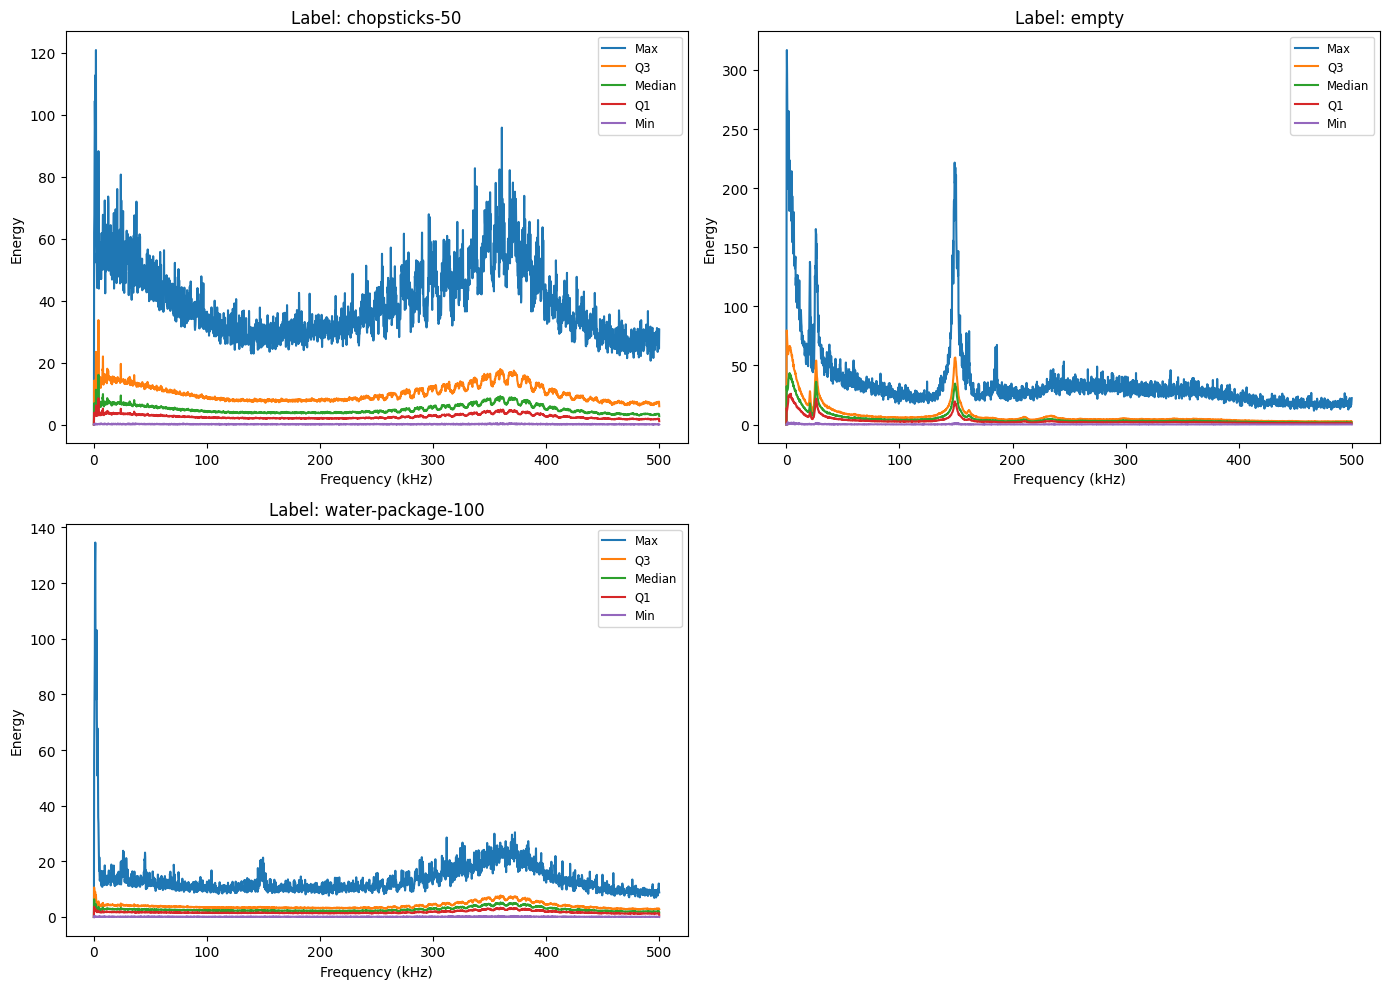

In [4]:
plot_spectrum_default(label_list, freq_list, spec_list, enabled_db, enabled_functions)

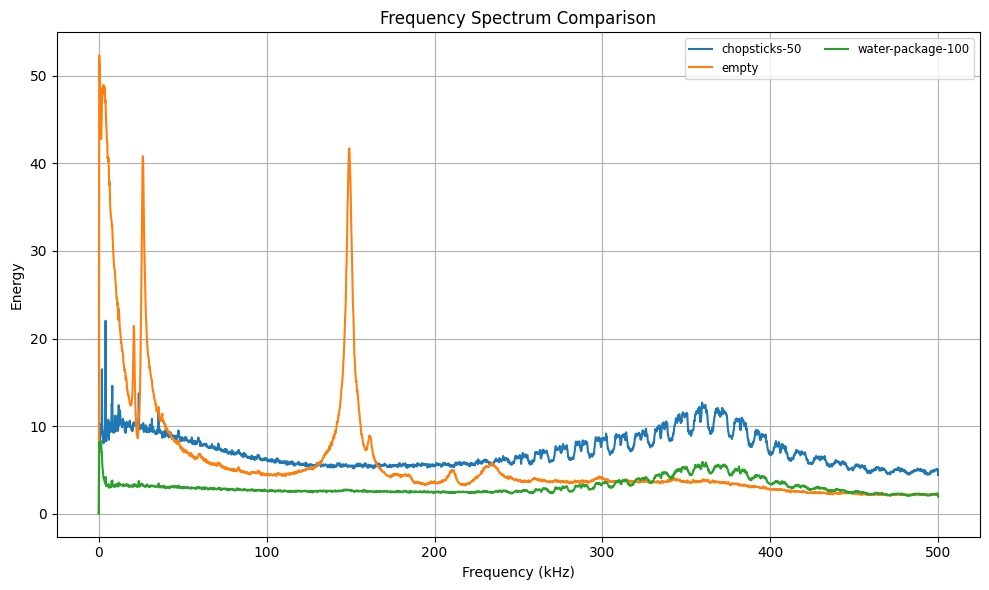

In [5]:
plot_spectrum(
    # presentage=50,
    label_list=label_list,
    freq_list=freq_list,
    
    spec_list=spec_list,
    # spec_list=spec_list / np.max(np.abs(spec_list), axis=1, keepdims=True),
    
    enabled_db=enabled_db,
    enabled_functions=enabled_functions,
    # figsize=np.array([10, 6]) * 2,
    
    custom_title='Frequency Spectrum Comparison',
)

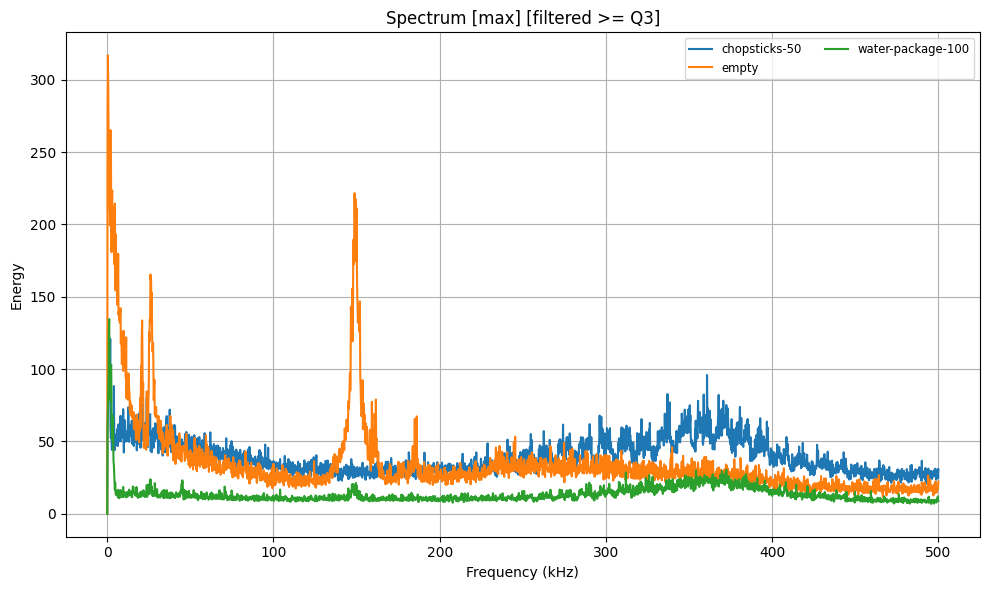

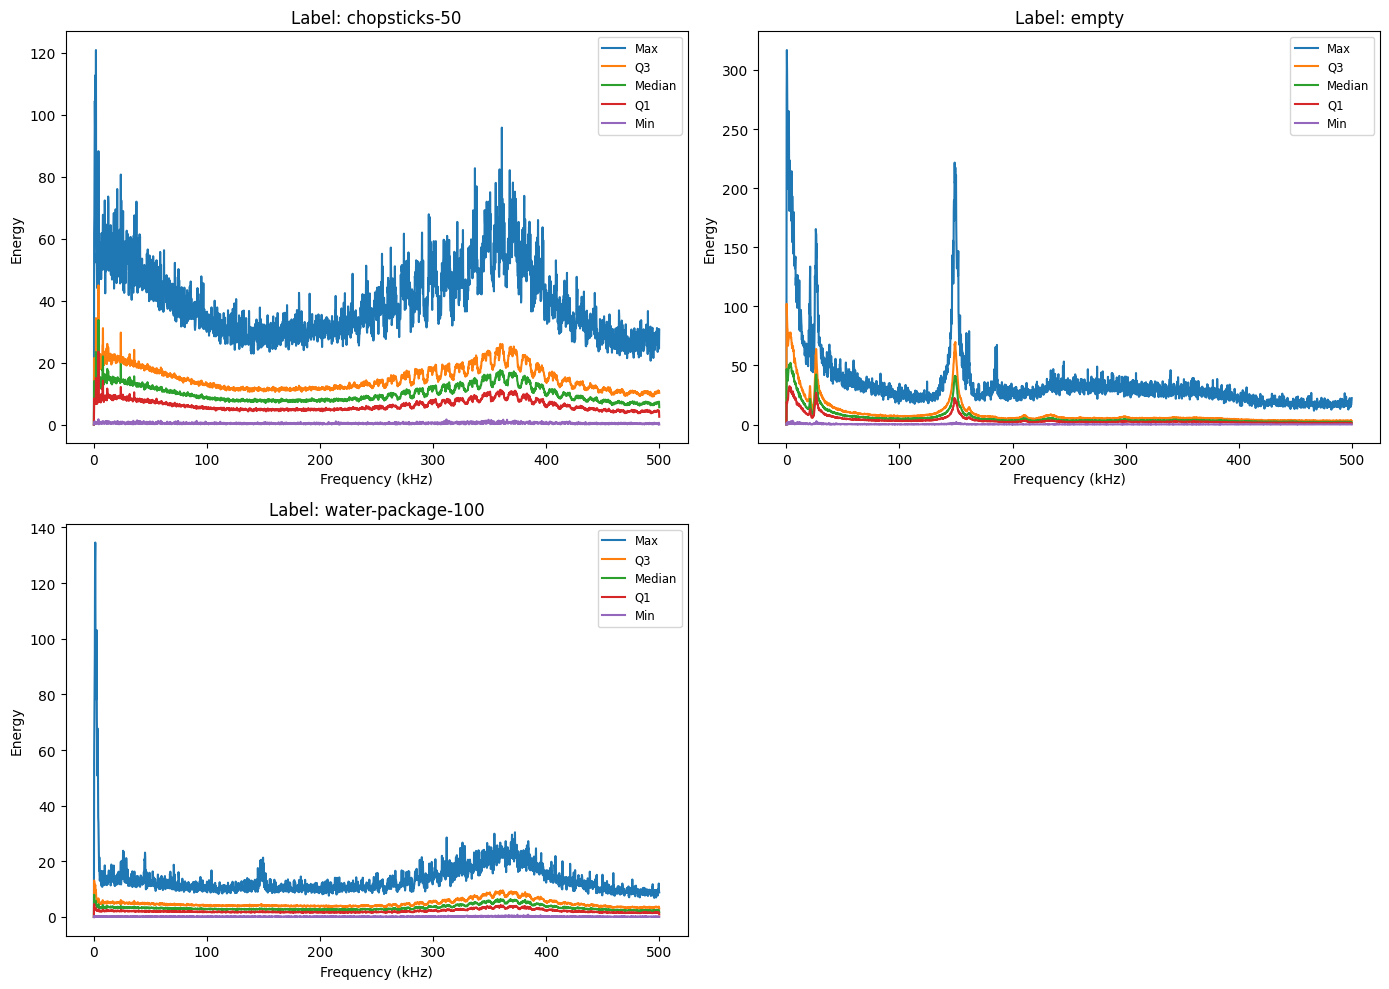

In [6]:
# 篩選Q3以上的資料（以每個樣本頻譜的總能量為例）
import numpy as np
from collections import defaultdict

# 計算每個 label 的樣本總能量
label_energy_map = defaultdict(list)
for label, spec in zip(label_list, spec_list):
    energy = np.sum(spec)
    label_energy_map[label].append(energy)

# 計算每個 label 的 Q3 能量
label_q3_map = {label: np.percentile(energies, 50) for label, energies in label_energy_map.items()}

# 篩選出總能量大於等於 Q3 的樣本
filtered_label_list = []
filtered_freq_list = []
filtered_spec_list = []
filtered_signal_list = []
for label, freq, spec, signal in zip(label_list, freq_list, spec_list, signal_list):
    energy = np.sum(spec)
    if energy >= label_q3_map[label]:
        filtered_label_list.append(label)
        filtered_freq_list.append(freq)
        filtered_spec_list.append(spec)
        filtered_signal_list.append(signal)

# 繪製篩選後的頻譜
plot_spectrum(
    presentage=100,
    label_list=filtered_label_list,
    freq_list=filtered_freq_list,
    spec_list=filtered_spec_list,
    enabled_db=enabled_db,
    enabled_functions=enabled_functions + ' [filtered >= Q3]',

)

plot_spectrum_default(filtered_label_list, filtered_freq_list, filtered_spec_list, enabled_db, enabled_functions)

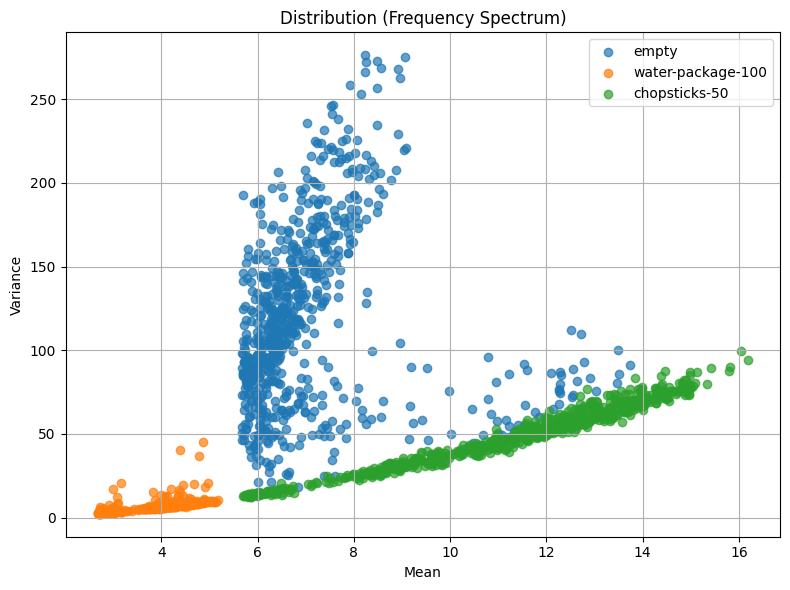

In [7]:
import numpy as np
import matplotlib.pyplot as plt

lbl_map = ['empty', 'water-package-100', 'chopsticks-50']

X = np.vstack(filtered_spec_list)

# 計算每個樣本的 mean 和 variance（以頻譜為例）
means = np.mean(X, axis=1)
variances = np.var(X, axis=1)

plt.figure(figsize=(8, 6))
for i in range(3):
    idx = np.where(np.array(filtered_label_list) == lbl_map[i])[0]
    plt.scatter(means[idx], variances[idx], label=lbl_map[i], alpha=0.7)

plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Distribution (Frequency Spectrum)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
from keras.src import layers, models, optimizers, callbacks, losses, metrics, regularizers

def detection_model():
    i = layers.Input(shape=(256, ))
    o = layers.Dense(300, activation='relu', activity_regularizer=regularizers.L1(0.00001))(i)
    o = layers.Dense(32, activation='relu', activity_regularizer=regularizers.L1(0.00001))(o)
    o = layers.Dense(3, activation='softmax')(o)
    return models.Model(inputs=i, outputs=o)

model = detection_model()
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy(name='accuracy')],
)

In [9]:
def X_Dataset_Factory():
    return np.abs(np.fft.rfft(filtered_signal_list, n=511))

def Y_Dataset_Factory():
    from tensorflow.keras.utils import to_categorical
    LABEL_MAP = {
        'empty': 0,
        'chopsticks-50': 1,
        'water-package-100': 2,
    }
    stratify = np.array([LABEL_MAP[label] for label in filtered_label_list])
    return stratify, to_categorical(stratify, num_classes=len(LABEL_MAP))

def Train_Test_Split():
    from sklearn.model_selection import train_test_split
    stratify, category = Y_Dataset_Factory()
    return train_test_split(
        X_Dataset_Factory(), category,
        test_size=0.2, random_state=42, stratify=stratify, shuffle=True
    )

X_Train, X_Test, Y_Train, Y_Test = Train_Test_Split()

In [10]:
history = model.fit(
    X_Train, Y_Train,
    validation_data=(X_Test, Y_Test),
    epochs=5000,
    batch_size=32,
    verbose=2,
    callbacks=[xc swe
        callbacks.ModelCheckpoint(
            filepath='blockage_detection.weights.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            mode='min',
            verbose=1
        ),
    ]
)

Epoch 1/5000

Epoch 1: val_loss improved from inf to 0.45305, saving model to blockage_detection.weights.h5
49/49 - 1s - 21ms/step - accuracy: 0.7266 - loss: 0.6624 - val_accuracy: 0.8468 - val_loss: 0.4531
Epoch 2/5000

Epoch 2: val_loss improved from 0.45305 to 0.37255, saving model to blockage_detection.weights.h5
49/49 - 0s - 4ms/step - accuracy: 0.8714 - loss: 0.4292 - val_accuracy: 0.8935 - val_loss: 0.3725
Epoch 3/5000

Epoch 3: val_loss did not improve from 0.37255
49/49 - 0s - 3ms/step - accuracy: 0.9227 - loss: 0.3067 - val_accuracy: 0.8597 - val_loss: 0.5038
Epoch 4/5000

Epoch 4: val_loss improved from 0.37255 to 0.30332, saving model to blockage_detection.weights.h5
49/49 - 0s - 4ms/step - accuracy: 0.9286 - loss: 0.2775 - val_accuracy: 0.9091 - val_loss: 0.3033
Epoch 5/5000

Epoch 5: val_loss did not improve from 0.30332
49/49 - 0s - 3ms/step - accuracy: 0.9584 - loss: 0.2103 - val_accuracy: 0.8987 - val_loss: 0.3377
Epoch 6/5000

Epoch 6: val_loss improved from 0.30332 t

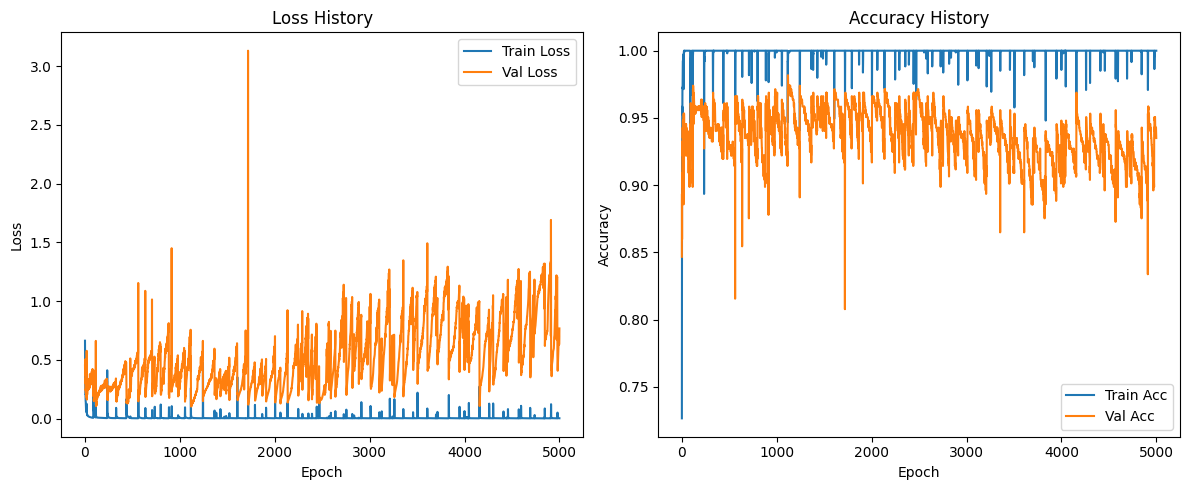

In [11]:
# 繪製訓練過程
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')
plt.tight_layout()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


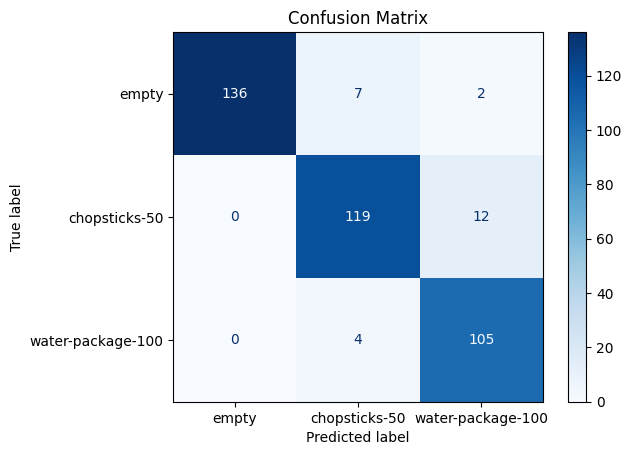

Weighted F1 Score: 0.9356


In [13]:
# 混淆矩陣與 F1 Score
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

# 預測
Y_pred_prob = model.predict(X_Test)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = np.argmax(Y_Test, axis=1)

# 混淆矩陣
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['empty', 'chopsticks-50', 'water-package-100']))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# F1 Score
f1 = f1_score(Y_true, Y_pred, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')